# Getting Started


## Install

```
pip install composeml
```

## Load Data
In this example, we have a data frame of transactions from different customers. To get an idea on how the data looks, we preview the data frame.

In [1]:
%matplotlib inline
from featuretools.demo import load_mock_customer

df = load_mock_customer(return_single_table=True)
df.set_index('transaction_time', inplace=True)

In [2]:
df[df.columns[:5]].head()

transaction_id  session_id product_id  amount  \
transaction_time                                                     
2014-01-01 00:00:00             298           1          5  127.64   
2014-01-01 00:09:45              10           1          5   57.39   
2014-01-01 00:14:05             495           1          5   69.45   
2014-01-01 02:33:50             460          10          5  123.19   
2014-01-01 02:37:05             302          10          5   64.47   

                     customer_id  
transaction_time                  
2014-01-01 00:00:00            2  
2014-01-01 00:09:45            2  
2014-01-01 00:14:05            2  
2014-01-01 02:33:50            2  
2014-01-01 02:37:05            2

## Create Labeling Function

We want to extract label times for each customer where the label equals the total purchase amount over the next hour of transactions. First, we define the function that will return the total purchase amount given a hour of transactions.

In [3]:
def my_labeling_function(df_slice):
    label = df_slice["amount"].sum()
    return label

In [4]:
from composeml import LabelMaker

label_maker = LabelMaker(
    target_entity="customer_id",
    time_index="transaction_time",
    labeling_function=my_labeling_function,
    window_size="1h",
)

## Generate Labels

With the label maker, we automatically search and extract the labels from the data frame by using `search`.

In [5]:
labels = label_maker.search(
    df,
    minimum_data="1h",
    num_examples_per_instance=25,
    gap=1,
    verbose=True,
)

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|████████████████████| customer_id: 5/5 


In [6]:
labels.head()

my_labeling_function
customer_id time                                     
1           2014-01-01 01:45:30               1143.11
            2014-01-01 03:29:05               2970.00
            2014-01-01 03:39:55               2859.48
            2014-01-01 04:14:35               2752.06
            2014-01-01 04:17:50               2618.57

## Transform Labels


### Threshold Label Values

Next, we make the lables binary by using a `threshold` for total purchase amounts above 1000.

In [7]:
labels = labels.threshold(3500)

In [8]:
labels.head()

my_labeling_function
customer_id time                                     
1           2014-01-01 01:45:30                 False
            2014-01-01 03:29:05                 False
            2014-01-01 03:39:55                 False
            2014-01-01 04:14:35                 False
            2014-01-01 04:17:50                 False

### Lead Label Times
We could also take those label times and shift the time 1 hour earlier for predicting in advance.

In [9]:
labels = labels.apply_lead('1h')

In [10]:
labels.head()

my_labeling_function
customer_id time                                     
1           2014-01-01 00:45:30                 False
            2014-01-01 02:29:05                 False
            2014-01-01 02:39:55                 False
            2014-01-01 03:14:35                 False
            2014-01-01 03:17:50                 False

## Describe Labels

With the labels, we could use `describe` to get the distribution and the settings used to make the labels.

In [11]:
labels.describe()

Total number of labels:  125

False    66
True     59
Name: my_labeling_function, dtype: int64

customer_id  my_labeling_function
1            False                   11
             True                    14
2            False                   17
             True                     8
3            False                   15
             True                    10
4            False                   13
             True                    12
5            False                   10
             True                    15
Name: count, dtype: int64

name                         my_labeling_function
target_entity                         customer_id
num_examples_per_instance                      25
minimum_data                                   1h
window_size                                    1h
gap                                             1
threshold                                    3500
lead                                           1h
dtype: object



## Plot Labels

### Label Distribution

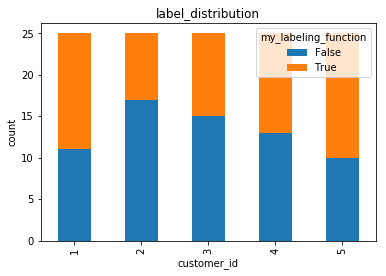

In [12]:
labels.plot.distribution(stacked=True)

### Label Count vs. Time

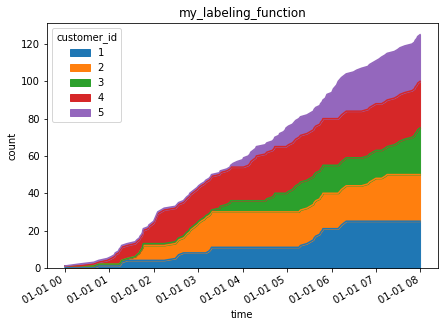

In [13]:
labels.plot.count_by_time(figsize=(7, 5))